# Overview
- nb068ベース(cv: 0.9356)
- mlp
- n_feats: 112
- n_fold=6  
- mod_batch7: True

# Const

In [3]:
NB = '070'
isSmallSet = False
if isSmallSet:
    LENGTH = 7000
else:
    LENGTH = 500_000

MOD_BATCH7 = True
MLP_DEEP = True
STANDARD_SCALER = True

PATH_TRAIN = './../data/input/train_clean.csv'
PATH_TEST = './../data/input/test_clean.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
DIR_OUTPUT_IGNORE = './../data/output_ignore/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [23]:
import warnings
warnings.filterwarnings('ignore')
import time
import gc
import itertools
import multiprocessing
import numpy as np
from scipy import signal
# from pykalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, mean_absolute_error, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.svm import SVR
from sklearn.linear_model import Lasso
# from dtreeviz.trees import dtreeviz
from keras.models import Model
from keras.optimizers import Adagrad
import keras.layers as L

# My function

In [5]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]

def add_category(train, test):
    train["category"] = 0
    test["category"] = 0
    
    # train segments with more then 9 open channels classes
    train.loc[2_000_000:2_500_000-1, 'category'] = 1
    train.loc[4_500_000:5_000_000-1, 'category'] = 1
    
    # test segments with more then 9 open channels classes (potentially)
    test.loc[500_000:600_000-1, "category"] = 1
    test.loc[700_000:800_000-1, "category"] = 1
    
    return train, test
    
def get_signal_mv_mean(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_std(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).std().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_min(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).min().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_max(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).max().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def calc_shifted(s, add_minus=False, fill_value=None, periods=range(1, 4)):
    s = pd.DataFrame(s)
    _periods = periods
    add_minus = True

    periods = np.asarray(_periods, dtype=np.int32)

    if add_minus:
        periods = np.append(periods, -periods)

    for p in progress_bar(periods):
        s[f"signal_shifted_{p}"] = s['signal'].shift(
            periods=p, fill_value=fill_value
        )

    cols = [col for col in s.columns if 'shifted' in col]
    return s[cols]



def group_feat_train(_train):
    train = _train.copy()
    # group init
    train['group'] = int(0)

    # group 1
    idxs = (train['batch'] == 3) | (train['batch'] == 7)
    train['group'][idxs] = int(1)

    # group 2
    idxs = (train['batch'] == 5) | (train['batch'] == 8)
    train['group'][idxs] = int(2)

    # group 3
    idxs = (train['batch'] == 2) | (train['batch'] == 6)
    train['group'][idxs] = int(3)

    # group 4
    idxs = (train['batch'] == 4) | (train['batch'] == 9)
    train['group'][idxs] = int(4)
    
    return train[['group']]

def group_feat_test(_test):
    test = _test.copy()
    # group init
    test['group'] = int(0)
    x_idx = np.arange(len(test))

    # group 1
    idxs = (100000<=x_idx) & (x_idx<200000)
    test['group'][idxs] = int(1)
    idxs = (900000<=x_idx) & (x_idx<=1000000)
    test['group'][idxs] = int(1)

    # group 2
    idxs = (200000<=x_idx) & (x_idx<300000)
    test['group'][idxs] = int(2)
    idxs = (600000<=x_idx) & (x_idx<700000)
    test['group'][idxs] = int(2)

    # group 3
    idxs = (400000<=x_idx) & (x_idx<500000)
    test['group'][idxs] = int(3)

    # group 4
    idxs = (500000<=x_idx) & (x_idx<600000)
    test['group'][idxs] = int(4)
    idxs = (700000<=x_idx) & (x_idx<800000)
    test['group'][idxs] = int(4)
    
    return test[['group']]


class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

def plot_corr(df, abs_=False, threshold=0.95):
    if abs_==True:
        corr = df.corr().abs()>threshold
        vmin = 0
    else:
        corr = df.corr()
        vmin = -1

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    fig.patch.set_facecolor('white')
    sns.heatmap(corr,
                xticklabels=df.corr().columns,
                yticklabels=df.corr().columns,
                vmin=vmin,
                vmax=1,
                center=0, 
                annot=False)

    # Decorations
    ax.set_title('Correlation', fontsize=22)

def get_low_corr_column(df, threshold):

    df_corr = df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return df_corr.columns  # 相関が高い特徴量を除いた名前リスト

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

def create_signal_mod(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        train['signal'][idxs_outlier]  = mean
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        train['signal'][idxs_outlier]  = mean
    return train

def create_signal_mod2(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()
        std = train[idxs_not_noisy]['signal'].std()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        noise = np.random.normal(loc=0, scale=std, size=len(train['signal'].values[idxs_outlier]))
        train['signal'][idxs_outlier]  = mean + noise
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        noise = np.random.normal(loc=0, scale=std, size=len(train['signal'].values[idxs_outlier]))
        train['signal'][idxs_outlier]  = mean + noise
    return train

In [6]:
def train_lgbm(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))
    oof_round = np.zeros(len(X))
    test_pred = np.zeros(len(X_te))
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMRegressor(**lgbm_params)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
        y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_pred_round = np.round(y_valid_pred).astype('int8')
        _test_pred = model.predict(X_te, model.best_iteration_)

        if show_fig==False:
            pass
        else:
            # permutation importance
            pi = permutation_importance(model, f1_macro) # model と metric を渡す
            pi.compute(X_valid, y_valid)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])

        # result
        oof[valid_idx] = y_valid_pred
        oof_round[valid_idx] = y_valid_pred_round
        score = f1_score(y_valid, y_valid_pred_round, average='macro')
        scores.append(score)
        test_pred += _test_pred
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y, oof_round, classes=np.arange(11))
        
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_pred = test_pred/N_FOLD
    test_pred_round = np.round(test_pred).astype('int8')
      
    return test_pred_round, test_pred, oof_round, oof, type(model).__name__

In [7]:
def train_test_split_lgbm(X, y, X_te, lgbm_params, random_state=5, test_size=0.3, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
#     folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    
    # prepare dataset
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # train
    model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=verbose,
              early_stopping_rounds=early_stopping_rounds)

    # pred
    oof = model.predict(X_valid, model.best_iteration_)
    oof_round = np.round(oof).astype('int8')
    test_pred = model.predict(X_te, model.best_iteration_)
    test_pred_round = np.round(test_pred).astype('int8')

    print('====== finish ======')
    print(f'oof score(f1_macro): {f1_score(y_valid, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y_valid, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y_valid, oof_round, classes=np.arange(11))
        
        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy
        plt.show()

    return test_pred_round, test_pred, oof_round, oof, type(model).__name__

In [8]:
def train_rfc(X, y, X_te, rfc_params, random_state=5, n_fold=5, verbose=2, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof_proba = np.zeros([len(X), len(np.unique(y))])
    test_proba = np.zeros([len(X_te), len(np.unique(y))])
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = RandomForestClassifier(**rfc_params, verbose=verbose)
        model.fit(X_train, y_train)

        # pred
        y_valid_pred = model.predict(X_valid)
        y_valid_proba = model.predict_proba(X_valid)
#         y_valid_pred_round = np.round(y_valid_pred).astype('int8')
        _test_pred = model.predict(X_te)
        _test_proba = model.predict_proba(X_te)

        if show_fig==False:
            pass
        else:
            # permutation importance
            pi = permutation_importance(model, f1_macro) # model と metric を渡す
            pi.compute(X_valid, y_valid)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])

        # result
        oof_proba[valid_idx] = y_valid_proba
        score = f1_score(y_valid, y_valid_pred, average='macro')
        scores.append(score)
        test_proba += _test_proba
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    oof = np.argmax(oof_proba, axis=1)
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y, oof, classes=np.arange(11))
        
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_proba = test_proba/N_FOLD 
    test_pred = np.argmax(test_proba, axis=1)
#     oof_pred = np.argmax(oof_proba, axis=1)
      
    return test_pred, test_proba, oof, oof_proba, type(model).__name__

In [9]:
def train_lgbm_clf(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof_proba = np.zeros([len(X), len(np.unique(y))])
    test_proba = np.zeros([len(X_te), len(np.unique(y))])
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMClassifier(**lgbm_params)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
#         y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_proba = model.predict_proba(X_valid, num_iteration=model.best_iteration_)
        y_valid_pred = np.argmax(y_valid_proba, axis=1)
#         _test_pred = model.predict(X_te, model.best_iteration_)
        _test_proba = model.predict_proba(X_te, num_iteration=model.best_iteration_)
        _test_pred = np.argmax(_test_proba, axis=1)

        if show_fig==False:
            pass
        else:
            # permutation importance
            pi = permutation_importance(model, f1_macro) # model と metric を渡す
            pi.compute(X_valid, y_valid)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])

        # result
        oof_proba[valid_idx] = y_valid_proba
        score = f1_score(y_valid, y_valid_pred, average='macro')
        scores.append(score)
        test_proba += _test_proba
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    oof = np.argmax(oof_proba, axis=1)
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y, oof, classes=np.arange(11))
        
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_proba = test_proba/N_FOLD 
    test_pred = np.argmax(test_proba, axis=1)
#     oof_pred = np.argmax(oof_proba, axis=1)
      
    return test_pred, test_proba, oof, oof_proba, type(model).__name__

<br>

ref: https://www.kaggle.com/martxelo/fe-and-ensemble-mlp-and-lgbm

In [10]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads


def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
#     wns = [0.3244]
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
#     wns = [0.0100, 0.0264, 0.0699, 0.3005, 0.4885, 0.7943]
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000, 3000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90).interpolate('spline', order=5, limit_direction='both')
    
    # add zeros when na values (std)
#     roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

def calc_ewm(s, windows=[10, 50, 100, 500, 1000, 3000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm



def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in progress_bar(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)

<br>

ref: https://www.kaggle.com/nxrprime/single-model-lgbm-kalman-filter-ii

In [11]:
def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

# Preparation

setting

In [12]:
sns.set()

<br>

load dataset

In [13]:
df_tr = pd.read_csv(PATH_TRAIN)
df_te = pd.read_csv(PATH_TEST)

<br>

処理のしやすさのために、バッチ番号を振る

In [14]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

batch_list = []
for n in range(4):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_te['batch'] = batch_list

<br>

group 特徴量

In [15]:
# group 特徴量を作成
group = group_feat_train(df_tr)
df_tr = pd.concat([df_tr, group], axis=1)

group = group_feat_test(df_te)
df_te = pd.concat([df_te, group], axis=1)

if isSmallSet:
    df_te['group'][1000:2000] = 1
    df_te['group'][2000:3000] = 2
    df_te['group'][3000:4000] = 3
    df_te['group'][4000:5000] = 4

<br>

group4にオフセットをかける

In [16]:
# --- train ---
off_set_4 = 0.952472 - (-1.766044)
off_set_9 = 0.952472 - (-1.770441)
# batch4
idxs = df_tr['batch'] == 4
df_tr['signal'][idxs] = df_tr['signal'].values + off_set_4
# batch9
idxs = df_tr['batch'] == 9
df_tr['signal'][idxs] = df_tr['signal'].values + off_set_9

# --- test ---
off_set_test = 2.750
df_te['signal'] = df_te['signal'].values
idxs = df_te['group'] == 4
df_te['signal'][idxs] = df_te['signal'][idxs].values + off_set_test

<br>

batch7のスパイク処理

In [17]:
if MOD_BATCH7:
    df_tr = create_signal_mod2(df_tr)

<br>

smallset?

In [18]:
if isSmallSet:
    print('small set mode')
    # train
    batchs = df_tr['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_tr['batch'].unique()):
        idxs = batchs == bt
        _df = df_tr[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_tr = pd.concat(dfs).reset_index(drop=True)
    
    # test
    batchs = df_te['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_te['batch'].unique()):
        idxs = batchs == bt
        _df = df_te[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_te = pd.concat(dfs).reset_index(drop=True)

# Train

In [19]:
def add_features(s):
    '''
    All calculations together
    '''
    feat_list = [s]
    feat_list.append(calc_gradients(s))
    feat_list.append(calc_low_pass(s))
    feat_list.append(calc_high_pass(s))
    feat_list.append(calc_roll_stats(s))
#     feat_list.append(calc_ewm(s))
    feat_list.append(calc_shifted(s, fill_value=0, periods=range(1, 4)))
    
    return pd.concat(feat_list, axis=1)

In [20]:
%%time
print(f'train start {time.ctime()}')
X = divide_and_add_features(df_tr['signal'], signal_size=LENGTH).reset_index(drop=True)
# _feats = get_low_corr_column(X, threshold=0.97).to_list()
# _feats.append('signal')
# X = X[_feats]
# X = reduce_mem_usage(X)

print(f'test start {time.ctime()}')
X_te = divide_and_add_features(df_te['signal'], signal_size=LENGTH).reset_index(drop=True)
# X_te = X_te[_feats]
# X_te = reduce_mem_usage(X_te)

y = df_tr['open_channels'].values

train start Sat May 16 18:11:07 2020


test start Sat May 16 18:17:37 2020


CPU times: user 2min 18s, sys: 7min, total: 9min 19s
Wall time: 9min 18s


In [25]:
if STANDARD_SCALER:
    feats = X.columns
    ss = StandardScaler()
    ss.fit(X)
    
    X = ss.transform(X)
    X_te = ss.transform(X_te)
    
    X = pd.DataFrame(X, columns=feats)
    X_te = pd.DataFrame(X_te, columns=feats)

In [26]:
X, X_te = add_category(X, X_te)

<br>

学習データセットの作成

In [27]:
def create_mpl_deep(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

def create_mpl_shallow(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(30, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [28]:
def train_mlp(X, y, X_te, random_state=5, n_fold=5, epoch=300, verbose=-1, show_fig=True):
    model_name = 'mlp_deep' if MLP_DEEP else 'mlp_shallow'
    
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof_proba = np.zeros([len(X), len(np.unique(y))])
    test_proba = np.zeros([len(X_te), len(np.unique(y))])
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        if MLP_DEEP:
            model = create_mpl_deep(X_train.values[0].shape)
            print('using mlp_deep model')
        else:
            model = create_mpl_shallow(X_train.values[0].shape)
            print('using mlp_shallow model')
        model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
        model.fit(x=X_train.values, y=y_train, 
                  epochs=epoch, 
#                   batch_size=1024, 
                  batch_size=2048, 
#                   class_weight=class_weight, 
                  validation_data=(X_valid.values, y_valid), verbose=1)


        # pred
        y_valid_proba = model.predict(X_valid)
        y_valid_pred = np.argmax(y_valid_proba, axis=1)
        _test_proba = model.predict(X_te)
        _test_pred = np.argmax(_test_proba, axis=1)
        plt.figure(1)
        plt.plot(model.history.history['loss'], 'b', label='loss')
        plt.plot(model.history.history['val_loss'], 'r', label='val_loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.figure(2)
        plt.plot(model.history.history['sparse_categorical_accuracy'], 'g', label='sparse_categorical_accuracy')
        plt.plot(model.history.history['val_sparse_categorical_accuracy'], 'r', label='val_sparse_categorical_accuracy')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()

        if show_fig==False:
            pass
        else:
            # permutation importance
            pi = permutation_importance(model, f1_macro) # model と metric を渡す
            pi.compute(X_valid, y_valid)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])

        # result
        oof_proba[valid_idx] = y_valid_proba
        score = f1_score(y_valid, y_valid_pred, average='macro')
        scores.append(score)
        test_proba += _test_proba
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    oof = np.argmax(oof_proba, axis=1)
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y, oof, classes=np.arange(11))
        
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_proba = test_proba/N_FOLD 
    test_pred = np.argmax(test_proba, axis=1)
#     oof_pred = np.argmax(oof_proba, axis=1)
      
    return test_pred, test_proba, oof, oof_proba, model_name

In [32]:
# Configuration
VERBOSE = 10               
N_FOLD = 6
KFOLD_SEED = 42
EPOCH = 40

features(112): 
Index(['signal', 'grad_1', 'grad_2', 'grad_3', 'grad_4', 'lowpass_lf_0.0100',
       'lowpass_ff_0.0100', 'lowpass_lf_0.0154', 'lowpass_ff_0.0154',
       'lowpass_lf_0.0239',
       ...
       'roll_q50_3000', 'roll_q75_3000', 'roll_q90_3000', 'signal_shifted_1',
       'signal_shifted_2', 'signal_shifted_3', 'signal_shifted_-1',
       'signal_shifted_-2', 'signal_shifted_-3', 'category'],
      dtype='object', length=112)

------------------
- Fold 1/6 started at Sat May 16 19:35:51 2020
using mlp_deep model
Train on 4166664 samples, validate on 833336 samples
Epoch 1/40
4166664/4166664 [==============================] - 33s 8us/step - loss: 0.1331 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.0891 - val_sparse_categorical_accuracy: 0.9653
Epoch 2/40
4166664/4166664 [==============================] - 28s 7us/step - loss: 0.0911 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.0929 - val_sparse_categorical_accuracy: 0.9637
Epoch 3/40
4166664/4166664 [========

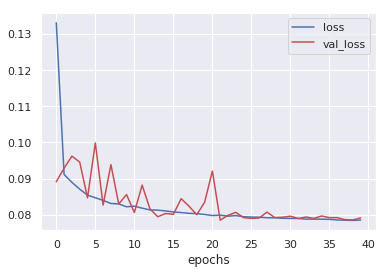

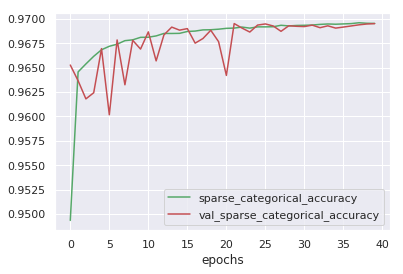

---> f1-score(macro) valid: 0.9387


------------------
- Fold 2/6 started at Sat May 16 20:01:46 2020
using mlp_deep model
Train on 4166665 samples, validate on 833335 samples
Epoch 1/40
4166665/4166665 [==============================] - 28s 7us/step - loss: 0.1386 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.0933 - val_sparse_categorical_accuracy: 0.9638
Epoch 2/40
4166665/4166665 [==============================] - 27s 7us/step - loss: 0.0965 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.0927 - val_sparse_categorical_accuracy: 0.9634
Epoch 3/40
4166665/4166665 [==============================] - 27s 6us/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.0880 - val_sparse_categorical_accuracy: 0.9656
Epoch 4/40
4166665/4166665 [==============================] - 26s 6us/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.0832 - val_sparse_categorical_accuracy: 0.9675
Epoch 5/40
4166665/4166665 [==============================] - 26s 6

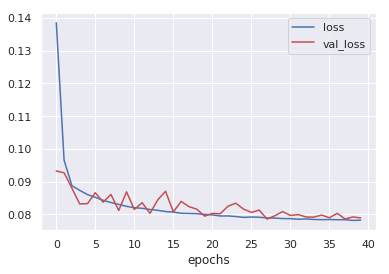

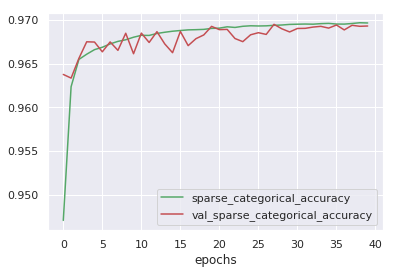

---> f1-score(macro) valid: 0.9380


------------------
- Fold 3/6 started at Sat May 16 20:24:32 2020
using mlp_deep model
Train on 4166665 samples, validate on 833335 samples
Epoch 1/40
4166665/4166665 [==============================] - 26s 6us/step - loss: 0.1368 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.0971 - val_sparse_categorical_accuracy: 0.9620
Epoch 2/40
4166665/4166665 [==============================] - 25s 6us/step - loss: 0.0912 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.0946 - val_sparse_categorical_accuracy: 0.9631
Epoch 3/40
4166665/4166665 [==============================] - 25s 6us/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.0877 - val_sparse_categorical_accuracy: 0.9662
Epoch 4/40
4166665/4166665 [==============================] - 24s 6us/step - loss: 0.0869 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0840 - val_sparse_categorical_accuracy: 0.9676
Epoch 5/40
4166665/4166665 [==============================] - 26s 6

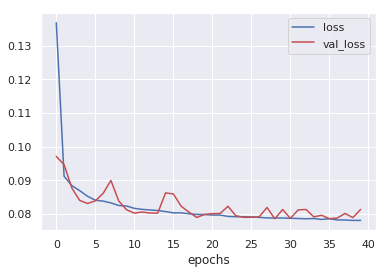

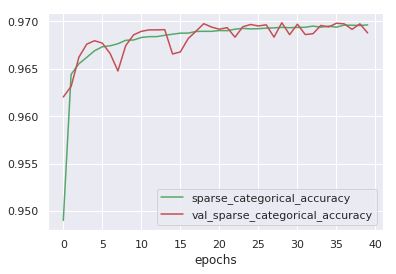

---> f1-score(macro) valid: 0.9369


------------------
- Fold 4/6 started at Sat May 16 20:43:51 2020
using mlp_deep model
Train on 4166666 samples, validate on 833334 samples
Epoch 1/40
4166666/4166666 [==============================] - 26s 6us/step - loss: 0.1472 - sparse_categorical_accuracy: 0.9438 - val_loss: 0.0908 - val_sparse_categorical_accuracy: 0.9647
Epoch 2/40
4166666/4166666 [==============================] - 26s 6us/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.0898 - val_sparse_categorical_accuracy: 0.9653
Epoch 3/40
4166666/4166666 [==============================] - 25s 6us/step - loss: 0.0887 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.0899 - val_sparse_categorical_accuracy: 0.9651
Epoch 4/40
4166666/4166666 [==============================] - 24s 6us/step - loss: 0.0932 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.0863 - val_sparse_categorical_accuracy: 0.9664
Epoch 5/40
4166666/4166666 [==============================] - 23s 5

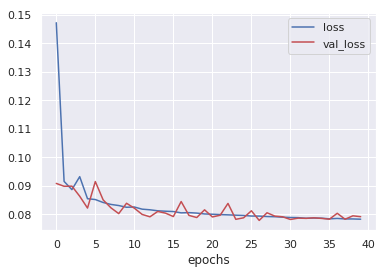

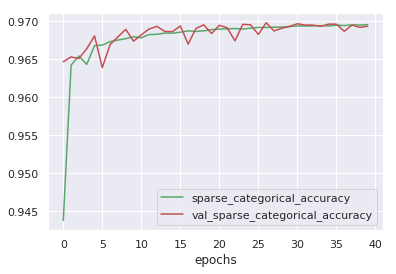

---> f1-score(macro) valid: 0.9386


------------------
- Fold 5/6 started at Sat May 16 21:03:49 2020
using mlp_deep model
Train on 4166668 samples, validate on 833332 samples
Epoch 1/40
4166668/4166668 [==============================] - 27s 6us/step - loss: 0.1474 - sparse_categorical_accuracy: 0.9443 - val_loss: 0.0886 - val_sparse_categorical_accuracy: 0.9654
Epoch 2/40
4166668/4166668 [==============================] - 23s 6us/step - loss: 0.0906 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.0877 - val_sparse_categorical_accuracy: 0.9658
Epoch 3/40
4166668/4166668 [==============================] - 24s 6us/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.0889 - val_sparse_categorical_accuracy: 0.9654
Epoch 4/40
4166668/4166668 [==============================] - 25s 6us/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.0849 - val_sparse_categorical_accuracy: 0.9670
Epoch 5/40
4166668/4166668 [==============================] - 25s 6

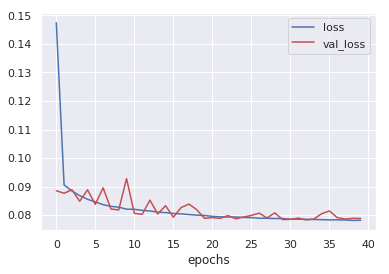

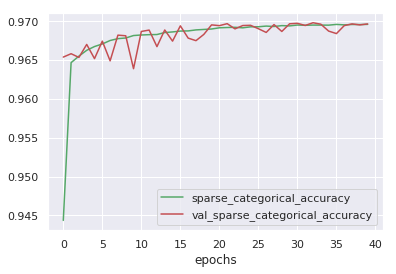

---> f1-score(macro) valid: 0.9385


------------------
- Fold 6/6 started at Sat May 16 21:25:30 2020
using mlp_deep model
Train on 4166672 samples, validate on 833328 samples
Epoch 1/40
4166672/4166672 [==============================] - 26s 6us/step - loss: 0.1469 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.1157 - val_sparse_categorical_accuracy: 0.9536
Epoch 2/40
4166672/4166672 [==============================] - 24s 6us/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.0855 - val_sparse_categorical_accuracy: 0.9668
Epoch 3/40
4166672/4166672 [==============================] - 24s 6us/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9667
Epoch 4/40
4166672/4166672 [==============================] - 26s 6us/step - loss: 0.0867 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0823 - val_sparse_categorical_accuracy: 0.9681
Epoch 5/40
4166672/4166672 [==============================] - 27s 6

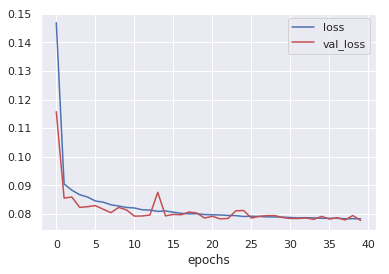

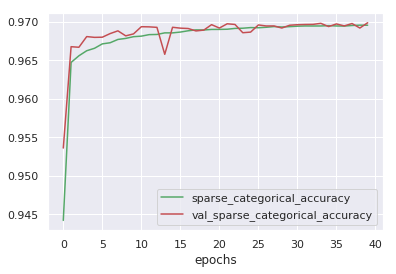

---> f1-score(macro) valid: 0.9390

====== finish ======
score list: [0.9386734122322244, 0.9379886676962474, 0.936867470537748, 0.9386394828844008, 0.9384763045267056, 0.9389653528980947]
CV mean score(f1_macro): 0.9383, std: 0.0007
oof score(f1_macro): 0.9383

CPU times: user 2h 39min 44s, sys: 31min 1s, total: 3h 10min 45s
Wall time: 2h 12min 36s


In [33]:
%%time
test_pred, test_proba, oof, oof_proba, model_name = train_mlp(X, y, X_te, 
                                                              n_fold=N_FOLD, 
                                                              verbose=VERBOSE, 
                                                              random_state=KFOLD_SEED, 
                                                              epoch=EPOCH,
                                                              show_fig=False)

# save

submission

In [34]:
save_path = f'{DIR_OUTPUT}submission_nb{NB}_{model_name}_cv_{f1_macro(y, oof):.4f}.csv'
sub = pd.read_csv(PATH_SMPLE_SUB)
# sub['open_channels'] = test_pred
sub['open_channels'] = test_pred.astype(int)
print(f'save path: {save_path}')

save path: ./../data/output/submission_nb070_mlp_deep_cv_0.9383.csv


In [35]:
sub.to_csv(save_path, index=False, float_format='%.4f')

<br>

oof proba

In [36]:
save_path = f'{DIR_OUTPUT_IGNORE}probas_nb{NB}_{model_name}_cv_{f1_macro(y, oof):.4f}'
print(f'save path: {save_path}')

save path: ./../data/output_ignore/probas_nb070_mlp_deep_cv_0.9383


In [37]:
np.savez_compressed(save_path, oof_proba, test_proba)

# analysis

<br>

処理のしやすさのために、バッチ番号を振る

In [38]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
X['batch'] = batch_list

<br>

group 特徴量

In [39]:
# group 特徴量を作成
group = group_feat_train(X)
X = pd.concat([X, group], axis=1)

In [40]:
for group in sorted(X['group'].unique()):
    idxs = X['group'] == group
    oof_grp = oof[idxs].astype(int)
    y_grp = y[idxs]
    print(f'group_score({group}): {f1_score(y_grp, oof_grp, average="micro"):4f}')

group_score(0): 0.999639
group_score(1): 0.985534
group_score(2): 0.977423
group_score(3): 0.997557
group_score(4): 0.886969


In [41]:
x_idx = np.arange(len(X))
idxs = y != oof

failed = np.zeros(len(X))
failed[idxs] = 1

In [42]:
n = 200
b = np.ones(n)/n
failed_move = np.convolve(failed, b, mode='same')

(0, 5500000)

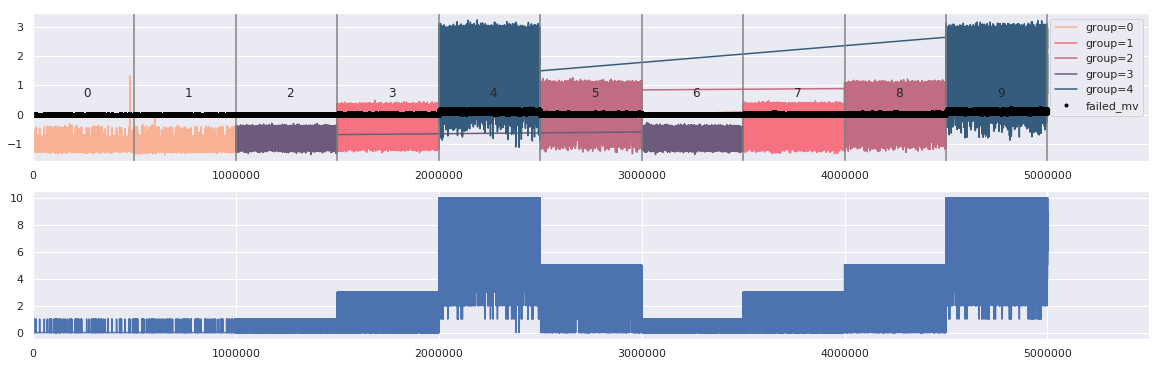

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(20, 6))
axs = axs.ravel()
# fig = plt.figure(figsize=(20, 3))

for i_gr, group in enumerate(sorted(X['group'].unique())):
    idxs = X['group'] == group
    axs[0].plot(np.arange(len(X))[idxs], X['signal'].values[idxs], color=cp[i_gr], label=f'group={group}')
for x in range(10): 
    axs[0].axvline(x*500000 + 500000, color='gray') 
    axs[0].text(x*500000 + 250000, 0.6, x)
axs[0].plot(x_idx, failed_move, '.', color='black', label='failed_mv')
axs[0].set_xlim(0, 5500000)
axs[0].legend()

axs[1].plot(x_idx, y)
axs[1].set_xlim(0, 5500000)

# fig.legend()